In [2]:
# Parameters
stormID = "default_id"
plan1_dir = "default/path/to/file.hdf"

# RAS2D Review Model outputs

This notebook analyzes model outputs of HECRAS2D production runs \
Created by: Arslaan Khalid \
Modified by:        \
.


In [3]:
import time, h5py
import notebook_utilities as nu
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, mapping, box
import matplotlib.pyplot as plt
import numpy as np

print( f'Last Updated: {time.ctime()}')

Last Updated: Tue Jul 22 16:00:51 2025


### RAS Model Outputs Working directories

In [4]:

# change here
# stormID='S0453'
# plan1_dir = r'V:\projects\p00860_coj_2023_cf_jf\01_processing\Baseline_Runs\base_model_no_infiltration\COJCOMPOUNDCOMPUTET.p01.hdf'

epsg_code_default = 6438
model1_name='COJ'

# stormID='S0129'
# plan1_dir = r'V:\projects\p00860_coj_2023_cf_jf\01_processing\Baseline_Runs\Ran_in_PSC\sample_plan\COJCOMPOUNDCOMPUTET.p01.tmp.hdf'

print('Input Attributes:')
print(f'-----------------\nModel Name: {model1_name}\nEPSG: {epsg_code_default}\nStormID : {stormID}')

print(f'plan1 dir : {plan1_dir}\n-----------------')

Input Attributes:
-----------------
Model Name: COJ
EPSG: 6438
StormID : S0129
plan1 dir : V:\projects\p00860_coj_2023_cf_jf\01_processing\Baseline_Runs\Ran_in_PSC\sample_plan\COJCOMPOUNDCOMPUTET.p01.tmp.hdf
-----------------


### Load RAS model info

In [15]:

try:
    # load hdf data
    data1 = nu.load_data(plan1_dir)
    mdl_name1 = nu.get_model_info(data1)
    print(f'HDF file loaded successfully')
    #print(f'\n----------\n{stormID}: Model loaded for {model1_name}\nFile path used: {data1.filename}\n----------\n') 
except:
    print(f'issues loading HDF file')
    #print(f'\n----------\n!!! {stormID}: Model not loaded for {model1_name}') 



# getting the model geometry
x, y, model_prj_epsg, epsg_code, cell_surface_area = nu.extract_geometry(data1, mdl_name1)
model_gdf = nu.create_geodataframe(x, y, epsg_code,cell_surface_area)

# getting perimeter
model_perimeter = pd.DataFrame(data1['Geometry/2D Flow Areas/PERIMTER1/Perimeter'][:])
model_perimeter.columns = ['x','y']


# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(model_perimeter['x'], model_perimeter['y'])]
gdf = gpd.GeoDataFrame(model_perimeter, geometry=geometry, crs=epsg_code_default)

# Create a Polygon from the points
polygon = Polygon(geometry)
model_boundary = gpd.GeoDataFrame(index=[0], geometry=[polygon], crs=epsg_code_default)

# Display the resulting polygon GeoDataFrame
# print(model_boundary)


# =============================================================================
#  get reference points
# =============================================================================
reference_points = data1['Geometry/Reference Points/Attributes'][:]
reference_coordinates = data1['Geometry/Reference Points/Points'][:]

# Extract the cell indices
gage_cell_indices = [entry[2] for entry in reference_points]

# Create a DataFrame
df = pd.DataFrame(reference_points, columns=['Name', 'SA/2D', 'Cell Index', 'USXSID', 'DSXSID', 'US Fraction'])

# Decode byte strings
df['Name'] = df['Name'].str.decode('utf-8')
df['SA/2D'] = df['SA/2D'].str.decode('utf-8')

# Add coordinates
df['X'],df['Y'] = [coord[0] for coord in reference_coordinates],[coord[1] for coord in reference_coordinates]
geometry = [Point(xy) for xy in zip(df['X'], df['Y'])]

gdf_reference = gpd.GeoDataFrame(df, geometry=geometry)

# print('Reference Points found in Geometry Data:\n')
# show(gdf_reference, lengthMenu=[len(gdf_reference)])


HDF file loaded successfully


### Debugging contents of the HDF file

In [16]:

# #Open the HDF5 file in read/write mode
# with h5py.File(plan1_dir, 'r') as hdf:
#     # List all datasets in the file
#     def find_datasets(name, obj):
#         if isinstance(obj, h5py.Dataset):
#             print(name)

#     print("Datasets in the file:")
#     hdf.visititems(find_datasets)


# with h5py.File(plan1_dir, 'r') as f:
#     #print(f.keys())
#     h5tree_view(f, include_keys=['Plan Data']) #,'Results



### Identify output fields 

In [17]:

available_results = nu.list_hdf_result_fields(data1, mdl_name1)

print(f'Available results: {available_results}')

Available results: ['2D Hyd Conn', 'Boundary Conditions', 'Computations', 'Face Velocity', 'Face Wind Velocity', 'Reference Points', 'Water Surface']


### Plan Information


In [18]:

plan1_info = {
    k: nu.clean_attr_value(v)
    for k, v in data1['Plan Data/Plan Information'].attrs.items()
}


_plan1 = pd.DataFrame(plan1_info.items()).set_index(0)

plan_info = pd.DataFrame(index = _plan1.index)
plan_info[f'{model1_name}-plan_info']=_plan1[1]
plan_info.index.names = ['Plan Information']

plan_info.head(10)
# show(plan_info, lengthMenu=[len(plan_info)])


,COJ-plan_info
Plan Information,
2D Initial Conditions Ramp Up Time (hrs),0.0
Base Output Interval,30MIN
Computation Time Step Base,30SEC
Flow Filename,COJCOMPOUNDCOMPUTET.u05
Flow Title,storm_0129_Baseline
Geometry Filename,COJCOMPOUNDCOMPUTET.g01
Geometry Title,BASE_020325
Plan Filename,COJCOMPOUNDCOMPUTET.p11
Plan Name,storm_0129_Baseline


### Plan parameters

In [19]:


plan1_param_keys = {
    k: nu.clean_attr_value(v)
    for k, v in data1['Plan Data/Plan Parameters'].attrs.items()
}



plan1_params = pd.DataFrame(plan1_param_keys.items()).set_index(0)

params_compare = pd.DataFrame(index = plan1_params.index)
params_compare[f'{model1_name}-plan_parameters']=plan1_params[1]
params_compare.index.names = ['Parameter Name']

params_compare.head(60)
# show(params_compare, lengthMenu=[len(params_compare)])

,COJ-plan_parameters
Parameter Name,
1D Cores,1
1D Flow Tolerance,NaN
1D Maximum Iterations,20
1D Maximum Iterations Without Improvement,0
1D Maximum Water Surface Error To Abort,100.0
1D Methodology,Finite Difference
1D Storage Area Elevation Tolerance,0.02
1D Theta,1.0
1D Theta Warmup,1.0


### Log file Info

In [20]:

def get_log_table(data):
    wsel_err= data.get('Results/Unsteady/Output/Output Blocks/Computation Block/2D Global/2D Iteration Error')[:]
    compute_time = data.get('Results/Unsteady/Output/Output Blocks/Computation Block/Global/Time Date Stamp (ms)')[:]#.decode('utf-8')
    iteration_block = data.get('Results/Unsteady/Output/Output Blocks/Computation Block/2D Global/2D Iterations')[:]


    compute_ = pd.DataFrame(iteration_block)
    compute_.columns = ['Number of Iterations' ,'2D Area pointer','Cell #']

    compute_.index = compute_time
    compute_['Error']=wsel_err
    return compute_


# Computations 
try:
    plan1_volume_keys = {
        k: nu.clean_attr_value(v)
        for k, v in data1['Results/Unsteady/Summary/Volume Accounting'].attrs.items()
    }

    
    _log1 = pd.DataFrame(plan1_volume_keys.items()).set_index(0)
    
    log_info = pd.DataFrame(index = _log1.index)
    log_info[f'{model1_name}']=_log1[1]
    
    log_info.index.names = ['Log Information']

    #show(log_info, lengthMenu=[len(log_info)])
    log_info.head(10)
except:
    print(f"No Volume Accounting data: {data1['Results/Unsteady/Summary'].keys()}\ndata1['Results/Unsteady/Summary/Volume Accounting']") 
    

## Landcover Check

14 Unique Manning values found
listed as : [ 0.098  0.12   0.038  0.09   0.02   0.068  0.04   0.115  0.03  10.
  0.027  0.15   0.14   0.035]


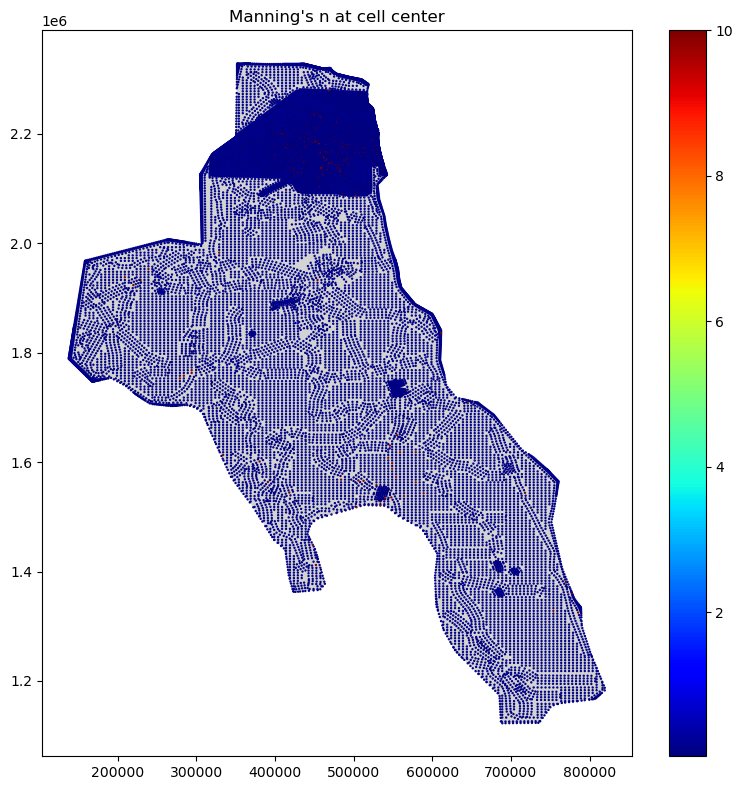

In [21]:
mannings_cell = data1["Geometry/2D Flow Areas/PERIMTER1/Cells Center Manning's n"][:]

model_gdf['manning']= mannings_cell

uniq_count  = model_gdf.manning.unique()
print(f'{len(uniq_count)} Unique Manning values found\nlisted as : {uniq_count}')


fig, ax = plt.subplots(1, 1, figsize=(8,8))

model_gdf.plot(column = 'manning',marker='.',legend=True,ax=ax,cmap='jet',markersize=2)
model_boundary.plot(ax=ax,zorder=-10,color='lightgray')
ax.set_aspect('auto'); 
ax.set_title(f"Manning's n at cell center")

plt.tight_layout()

### Initial Conditions

In [22]:
iC_gdf = nu.extract_IC_gdf(data1)
# display(iC_gdf)

iC_gdf.head(50)

,name,elevation,fixed,2D area,cell ID,geometry
0,IC Points 1,-0.270000,0,PERIMTER1,308078,POINT (529089.908 2205705.829)
1,IC Points 2,5.170000,0,PERIMTER1,218347,POINT (409861.703 2298415.316)
2,IC Points 4,3.480000,0,PERIMTER1,17140,POINT (419241.518 2254264.83)
3,IC Points 5,8.710000,0,PERIMTER1,218352,POINT (433819.06 2299147.429)
4,IC Points 6,-0.340000,0,PERIMTER1,328680,POINT (521892.959 2155739.7)
5,IC Points 7,-0.240000,0,PERIMTER1,333048,POINT (444199.937 2223360.238)
6,IC Points 8,-0.150000,0,PERIMTER1,337625,POINT (450450.783 2225110.119)
7,IC Points 9,-0.230000,0,PERIMTER1,337900,POINT (415181.466 2220137.124)
8,IC Points 10,0.310000,0,PERIMTER1,347214,POINT (420681.537 2209525.404)
9,IC Points 11,-0.170000,0,PERIMTER1,310798,POINT (423977.01 2196518.509)


## Extract Outputs

### Water Surface Elevation

In [ ]:

df_wse_model1 = nu.extract_result_field(data1,mdl_name1,'Water Surface')

# along timeseries and then the max
model_gdf['max_wse'] = df_wse_model1.max() 
model_gdf['min_wse'] = df_wse_model1.min() 

summary_table_wse = model_gdf['max_wse'].describe().to_frame(name='max WSE')
# display(summary_table_wse)

### Flood depth

In [ ]:

print('''
flood depth timeseries = Modeled WSE at all times - Modeled WSE at time 0

max flood depth = maximum of flood depth timeseries

flood depth difference = max flood depth model1 - max flood depth model2
''')


fdepth1 = df_wse_model1-df_wse_model1.iloc[0]

model_gdf['max_depth'] = fdepth1.max()
model_gdf['min_depth'] = fdepth1.min()


summary_table_fdep = model_gdf['max_depth'].describe().to_frame(name='max Flood Depth')
# display(summary_table_fdep)

### Velocity

In [ ]:

summary_table_vel = pd.DataFrame(index=summary_table_fdep.index)
if 'Cell Velocity - Velocity X' in available_results:
    # load velocities
    df_velx = nu.extract_result_field(data1,mdl_name1,'Cell Velocity - Velocity X')
    df_vely = nu.extract_result_field(data1,mdl_name1,'Cell Velocity - Velocity Y')
    
    df_vel = np.sqrt(df_velx**2 + df_vely**2)
    
    
    # along timeseries and then the max
    model_gdf['max_vel'] = df_vel.max() 
    model_gdf['min_vel'] = df_vel.min() 
    
    summary_table_vel = model_gdf['max_vel'].describe().to_frame(name='max Vel')
    # display(summary_table_vel)
else:
    print('Warning!: Cell velocity outputs are not found in the plan file')
    

### Cell Flow Balance

In [ ]:
summary_table_flow_bal = pd.DataFrame(index=summary_table_fdep.index)
if 'Cell Flow Balance' in available_results:
    df_flowbalance = nu.extract_result_field(data1,mdl_name1,'Cell Flow Balance')
    
    model_gdf['max_flowbalance'] = df_flowbalance.max() 
    
    summary_table_flow_bal = model_gdf['max_flowbalance'].describe().to_frame(name='max Flow Balance')
    # display(summary_table_flow_bal)

else:
    print('Warning!: Cell Flow balance outputs are not found in the plan file')


### Cell Volume 

In [ ]:
summary_table_vol = pd.DataFrame(index=summary_table_fdep.index)
if 'Cell Volume' in available_results:
    df_volume = nu.extract_result_field(data1,mdl_name1,'Cell Volume')
    
    model_gdf['max_vol'] = df_volume.max() 
    model_gdf['min_vol'] = df_volume.min() 
    
    summary_table_vol = model_gdf['max_vol'].describe().to_frame(name='max Volume')
    # display(summary_table_vol)

else:
    print('Warning!: Cell Volume outputs are not found in the plan file')


### Summary Statistics of Model Output Maximum Values

In [ ]:


# Combine all summary tables into a single DataFrame
combined_summary_table = pd.concat([
    summary_table_wse,
    summary_table_vel,
    summary_table_fdep,
    summary_table_vol,
    summary_table_flow_bal
], axis=1)



# Display the combined summary table
# display(combined_summary_table)

combined_summary_table.round(2).iloc[1:].head(10)



## Spatial Plot

### Flood Depth and Max WSE

In [ ]:

field_to_plot =['max_depth','max_wse']

# plot spatial difference 
fig, ax = plt.subplots(1, 2, figsize=(10,8))

for i in range(2): 
    if i==0:       model_gdf[model_gdf[field_to_plot[i]]>0.0001].plot(column = field_to_plot[i],marker='.',legend=True,ax=ax[i],cmap='viridis',markersize=1)
    elif i==1:       model_gdf.plot(column = field_to_plot[i],marker='.',legend=True,ax=ax[i],cmap='viridis',markersize=2)
    model_boundary.plot(ax=ax[i],zorder=-10,color='lightgray')
    ax[i].set_aspect('auto'); 
    ax[i].set_title(f'{field_to_plot[i]} in feet')

plt.tight_layout()




### Cell Center Velocity

In [ ]:

if 'Cell Velocity - Velocity X' in available_results:
    field_to_plot =['max_vel','max_vel']
    
    # plot spatial difference 
    fig, ax = plt.subplots(1, 2, figsize=(12,8))
    
    for i in range(2): 
        if i==0:       model_gdf[(model_gdf[field_to_plot[i]]>0.01) & (model_gdf[field_to_plot[i]]<10)].plot(column = field_to_plot[i],marker='.',legend=True,ax=ax[i],cmap='viridis',markersize=1)
        else:       model_gdf[model_gdf[field_to_plot[i]]>10].plot(column = field_to_plot[i],marker='.',legend=True,ax=ax[i],cmap='viridis',markersize=0.5)
        model_boundary.plot(ax=ax[i],zorder=-10,color='lightgray')
        ax[i].set_aspect('auto'); 
        ax[i].set_title(f'{field_to_plot[i]} in ft/s')
    plt.tight_layout()

else:
    print('Warning!: Cell velocity outputs are not found in the plan file')

## Plot timeseries at Reference Points

### Water Surface Elevation

In [ ]:
for ids in gdf_reference.index:
    cell_info = gdf_reference.iloc[ids]
    df_wse_model1[cell_info['Cell Index']].plot()

plt.ylabel('Water Surface Elevation in feet')
plt.xlabel('Time enteries')


### Cell Velocity

In [ ]:

if 'Cell Velocity - Velocity X' in available_results:
    for ids in gdf_reference.index:
        cell_info = gdf_reference.iloc[ids]
        df_vel[cell_info['Cell Index']].plot()
    
    plt.ylabel('Cell Velocity in ft/s')
    plt.xlabel('Time enteries')
else:
    print('Warning!: Cell velocity outputs are not found in the plan file')

### Flow Balance

In [ ]:
if 'Cell Flow Balance' in available_results:
    for ids in gdf_reference.index:
        cell_info = gdf_reference.iloc[ids]
        df_flowbalance[cell_info['Cell Index']].plot()
    
     
    plt.ylabel('Cell Flow Balance')
    plt.xlabel('Time enteries')   
else:
    print('Warning!: Cell Flow Balance outputs are not found in the plan file')

### Cell Volume

In [ ]:
if 'Cell Flow Balance' in available_results:
    for ids in gdf_reference.index:
        cell_info = gdf_reference.iloc[ids]
        df_volume[cell_info['Cell Index']].plot()
    
    plt.ylabel('Cell Volume')
    plt.xlabel('Time enteries')   
else:
    print('Warning!: Cell Volume outputs are not found in the plan file')
    

## Event Forcings

### Winds

In [ ]:
# load event conditions
_,ts1, model1_windx, model1_windy = nu.extract_event_field(data1,'Wind')

df_wind = np.sqrt(model1_windx**2 + model1_windy**2)

df_wind_2d = pd.DataFrame(df_wind)

df_wind_2d_max = df_wind_2d.max(axis=1)


summary_table = df_wind_2d_max.describe().to_frame(name='max Wind [Summary Statistics]')
#display(summary_table)

summary_table.round(2).iloc[1:].head(10)

# pick 5 random locations and plot
df_wind_2d_no_nan = df_wind_2d.loc[:, (df_wind_2d != 0).any(axis=0)]
df_wind_2d_sample = df_wind_2d_no_nan.sample(5,axis=1)


for cols in df_wind_2d_sample.columns:
    df_wind_2d_sample[cols].plot()

plt.ylabel('Wind Magnitude in ft/s')
plt.xlabel('Time enteries')

In [ ]:
df_wind_2d_T = df_wind_2d.T

In [ ]:


# Calculate the 5th percentile, 95th percentile, and median across rows for each column
q5 = df_wind_2d_T.quantile(0.05)
q95 = df_wind_2d_T.quantile(0.95)
median = df_wind_2d_T.median()

# Plotting the time series
plt.figure(figsize=(14, 6))
plt.plot(q5.index, q5.values, label='5th Percentile', color='blue', alpha=0.7)
plt.plot(median.index, median.values, label='Median', color='green', alpha=0.7)
plt.plot(q95.index, q95.values, label='95th Percentile', color='red', alpha=0.7)


# Fill between 5th and 95th percentiles
plt.fill_between(q5.index, q5.values, q95.values, color='gray', alpha=0.3, label='5th-95th Range')


plt.title('Wind Time Series Plot: 5th and 95th Percentile')
plt.xlabel('Time Step')
plt.ylabel('Value')


### Boundary Conditions

In [ ]:

# load boundary stage conditions
model1_ND, model1_BC = nu.extract_event_field(data1,'Boundary Conditions')

model1_BC[model1_BC<-100]=np.nan
print('Normal Depth:')
print(model1_ND)

print('Downstream: Stage Hydrograph:')
# print(model1_BC.describe())


plt.figure()
model1_BC[1].plot(label='Start')
model1_BC[len(model1_BC.columns)/2].plot(label='Middle')
model1_BC[len(model1_BC.columns)-1].plot(label='End')
plt.legend()

plt.ylabel('Downstream Water surface elevation in feet')
plt.xlabel('Time enteries')



In [ ]:
# interaction WSE timeseries plot

In [ ]:

# for ids in gdf_reference.index:

#     cell_info = gdf_reference.iloc[ids]

    
#     # Interactive time series plot of WSE differences
#     fig_ts = go.Figure()

#     fig_ts.add_trace(go.Scatter(
#         x=df_wse_model1.index,
#         y=df_wse_model1[cell_id],
#         mode='lines',
#         opacity=0.8,
#         name=str(model1_name)
#     ))

#     fig_ts.update_layout(
#         title=f'Timeseries of WSE at Gage: {cell_info['Name']} Cell ID: {cell_info['Cell Index']}\n',
#         xaxis_title='Datetime',
#         yaxis_title='WSE (feet)',
#         height=400,
#         width=1200
#     )

#     # Show plots
#     fig_ts.show()